In [1]:
import os
import torch

# GPU 2를 사용하도록 환경 변수 설정
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 현재 사용 중인 GPU ID 확인
current_device = torch.cuda.current_device()
print(f"Current CUDA device: {current_device}")

# 현재 사용 중인 GPU 이름 확인
current_device_name = torch.cuda.get_device_name(current_device)
print(f"Current CUDA device name: {current_device_name}")

# 실제로 설정된 환경 변수를 확인
print(f"CUDA_VISIBLE_DEVICES: {os.environ.get('CUDA_VISIBLE_DEVICES')}")

Using device: cuda
Current CUDA device: 0
Current CUDA device name: NVIDIA RTX A5000
CUDA_VISIBLE_DEVICES: 1


In [2]:
import cv2
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [4]:
def image_to_patches(image, patch_size=512): # 이미지를 패치로 나누는 함수
    patches = []
    for i in range(0, image.shape[0], patch_size):
        for j in range(0, image.shape[1], patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                continue  # Skip patches that are smaller than patch_size
            patches.append(patch)
    return patches

class SatelliteDataset(Dataset):
    def __init__(self, image_dir, mask_dir, patch_size=512, transform=None, infer=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.infer = infer
        self.patch_size = patch_size
        self.image_files = sorted(os.listdir(image_dir)) # 이미지 파일 목록 정렬
        self.mask_files = sorted(os.listdir(mask_dir)) # 마스크 파일 목록 정렬

    def __len__(self):
        num_patches_per_image = (1920 // self.patch_size) ** 2
        return len(self.image_files) * num_patches_per_image  # 전체 데이터를 사용

    def __getitem__(self, idx):
        num_patches_per_image = (1920 // self.patch_size) ** 2 # 이미지당 패치 수
        img_idx = idx // num_patches_per_image # 이미지 인덱스
        patch_idx = idx % num_patches_per_image

        img_path = os.path.join(self.image_dir, self.image_files[img_idx]) # 이미지 경로
        mask_path = os.path.join(self.mask_dir, self.mask_files[img_idx])

        image = cv2.imread(img_path) # 이미지 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 채널 변경

        if self.infer: # 추론 시, 사실상 test dataset이 없으므로 없는 코드 
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # 이미지와 마스크를 패치로 나누기
        image_patches = image_to_patches(image, self.patch_size)
        mask_patches = image_to_patches(mask, self.patch_size)

        image = image_patches[patch_idx] # 이미지 패치
        mask = mask_patches[patch_idx]

        if self.transform: # 각 epoch마다 getitem을 통해 이미지와 마스크를 변환
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

# 데이터 증강 파이프라인 설정 (훈련용)
train_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5), # 50% 확률로 좌우 반전
        A.VerticalFlip(p=0.5), # 50% 확률로 상하 반전
        A.RandomRotate90(p=0.5), # 50% 확률로 90도 회전
        # A.RandomBrightnessContrast(p=0.2),
        # A.OneOf([
        #     A.GaussianBlur(p=0.1),
        #     A.MotionBlur(p=0.1),
        # ], p=0.2),
        # A.ElasticTransform(p=0.1),
        A.Normalize(),
        ToTensorV2()
    ]
)

# 데이터 증강 파이프라인 설정 (검증용)
val_transform = A.Compose(
    [
        A.Normalize(),
        ToTensorV2()
    ]
)
# 데이터셋 인스턴스 생성
image_dir = './buildings/train_images'
mask_dir = './buildings/train_masks'

full_dataset = SatelliteDataset(image_dir=image_dir, mask_dir=mask_dir, patch_size=384, transform=None)

# 데이터셋을 train과 validation으로 분할
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size


# 랜덤 시드 설정
set_seed(42)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 각각의 데이터셋에 대해 다른 변환 적용
train_dataset = Subset(SatelliteDataset(image_dir=image_dir, mask_dir=mask_dir, 
                                        patch_size=384, transform=train_transform), train_dataset.indices)

val_dataset = Subset(SatelliteDataset(image_dir=image_dir, mask_dir=mask_dir, 
                                      patch_size=384, transform=val_transform), val_dataset.indices)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False, num_workers=4)

# 데이터셋 길이 확인
print(len(full_dataset))

# 데이터셋 길이 확인
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")

1000
Train dataset length: 800
Validation dataset length: 200


torch.Size([3, 384, 384]) torch.Size([384, 384])


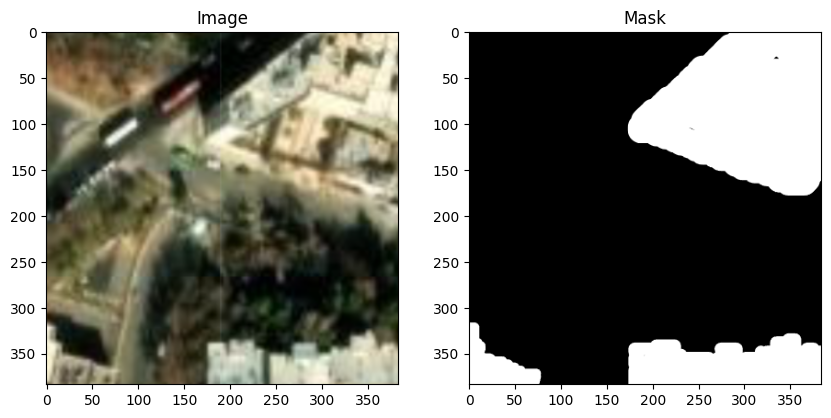

In [5]:

# 데이터 포인트 확인
image, mask = val_dataset[1]
print(image.shape, mask.shape)

def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# 이미지와 마스크를 시각화하는 함수
def visualize_sample(image, mask, mean, std):
    image = denormalize(image, mean, std)
    image = image.permute(1, 2, 0).cpu().numpy()  # 채널을 마지막으로 배치하고 numpy 배열로 변환
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)  # 역정규화된 이미지를 시각화
    ax[0].set_title('Image')
    ax[1].imshow(mask.cpu().numpy(), cmap='gray')
    ax[1].set_title('Mask')
    plt.show()

# 시각화
visualize_sample(image, mask, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [6]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)  # Sigmoid activation to get probability
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        return bce_loss + dice_loss
    
def dice_score(inputs, targets, smooth=1):
    inputs = torch.sigmoid(inputs)  # Sigmoid activation to get probability
    inputs = (inputs > 0.5).float()  # Binarize the outputs at 0.5 threshold
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()
    dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
    return dice.item()

In [9]:
import torchvision

resnet = torchvision.models.resnet.resnet50(pretrained=True)

class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """

        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=1):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

/home/a2024712006/miniconda3/envs/hwany_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/a2024712006/miniconda3/envs/hwany_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
import segmentation_models_pytorch as smp
# hyper parameters 
epoch_num = 50
learning_rate = 0.001
patience = 4 # patience 횟수 동안 validation loss가 개선되지 않으면 학습을 조기 중지
early_stopping_counter = 5 # counter동안 validation loss가 개선되지 않으면 학습을 조기 중지
best_val_loss = float('inf')

# model 초기화 
# model = smp.Unet(
#     encoder_name="resnet50",          # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=1,                      # model output channels (number of classes in your dataset)
# )
# model = model.to(device)
model = UNetWithResnet50Encoder().to(device)

# loss function과 optimizer 정의
criterion = BCEDiceLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.1, patience=patience)

# 손실 기록을 위한 리스트
train_losses = []
val_losses = []

best_epoch = 0
# training loop
for epoch in range(epoch_num):  # 30 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_loader):
        images = images.float().to(device) # 이미지와 마스크를 GPU로 이동
        masks = masks.float().to(device)
        masks = masks / 255  # 마스크를 0과 1로 변환

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
    train_losses.append(epoch_loss / len(train_loader)) # training loss 기록
    print(f'Train Epoch {epoch+1}, Loss: {train_losses[-1]}')

    model.eval()
    with torch.no_grad():
        epoch_val_loss = 0
        epoch_val_dice = 0
        for images, masks in tqdm(val_loader):
            images = images.float().to(device) # 이미지와 마스크를 GPU로 이동
            masks = masks.float().to(device)
            masks = masks / 255  # 마스크를 0과 1로 변환

            outputs = model(images)
            val_loss = criterion(outputs, masks.unsqueeze(1))
            epoch_val_loss += val_loss.item()
            epoch_val_dice += dice_score(outputs, masks.unsqueeze(1))

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss) # validation loss 기록
        avg_val_dice = epoch_val_dice / len(val_loader)
        print(f'Val Epoch {epoch+1}, Loss: {avg_val_loss}, Dice Score: {avg_val_dice}')


        scheduler.step(avg_val_loss) # patience 동안 avg_val_loss가 개선되지 않으면 lr을 감소시킵니다.
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Learning Rate for Epoch {epoch+1}: {current_lr}')

        # Save the best model and apply early stopping
        if avg_val_loss < best_val_loss: 
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pt') # validation loss가 감소하면 모델을 저장
            best_epoch = epoch + 1
            print("best epoch: ", best_epoch)
            # early_stopping_counter = 0  # Reset counter
        # else:
        #     early_stopping_counter += 1  # Increment counter
        #     if early_stopping_counter >= patience:
        #         print("Early stopping, best epoch: ", best_epoch)
        #         break
print("Training finished!, best epoch: ", best_epoch)

  0%|          | 0/40 [00:00<?, ?it/s]/home/a2024712006/miniconda3/envs/hwany_env/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 1, Loss: 0.903803662955761


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Val Epoch 1, Loss: 0.7689958930015564, Dice Score: 0.6556259423494339
Learning Rate for Epoch 1: 0.001
best epoch:  1


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 2, Loss: 0.6846007153391838


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Val Epoch 2, Loss: 0.6191815197467804, Dice Score: 0.7363805174827576
Learning Rate for Epoch 2: 0.001
best epoch:  2


100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Epoch 3, Loss: 0.6124711811542511


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 3, Loss: 0.6290532231330872, Dice Score: 0.7181585729122162
Learning Rate for Epoch 3: 0.001


100%|██████████| 40/40 [00:26<00:00,  1.54it/s]


Train Epoch 4, Loss: 0.6191623575985432


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Val Epoch 4, Loss: 0.5882139176130294, Dice Score: 0.7484813094139099
Learning Rate for Epoch 4: 0.001
best epoch:  4


100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Epoch 5, Loss: 0.5885022476315498


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Val Epoch 5, Loss: 0.6541245192289352, Dice Score: 0.731728583574295
Learning Rate for Epoch 5: 0.001


100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Epoch 6, Loss: 0.5584163852035999


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Val Epoch 6, Loss: 0.5258619219064713, Dice Score: 0.7887936592102051
Learning Rate for Epoch 6: 0.001
best epoch:  6


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 7, Loss: 0.5139227896928787


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Val Epoch 7, Loss: 0.5416096359491348, Dice Score: 0.7677728235721588
Learning Rate for Epoch 7: 0.001


100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Epoch 8, Loss: 0.537923426926136


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 8, Loss: 0.48006625175476075, Dice Score: 0.7938218891620636
Learning Rate for Epoch 8: 0.001
best epoch:  8


100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Epoch 9, Loss: 0.5096812963485717


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 9, Loss: 0.7566017717123031, Dice Score: 0.6784342586994171
Learning Rate for Epoch 9: 0.001


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 10, Loss: 0.5004768922924996


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Val Epoch 10, Loss: 0.43084290623664856, Dice Score: 0.8189661741256714
Learning Rate for Epoch 10: 0.001
best epoch:  10


100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Train Epoch 11, Loss: 0.5011723458766937


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Val Epoch 11, Loss: 0.5570916444063186, Dice Score: 0.7419696867465972
Learning Rate for Epoch 11: 0.001


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 12, Loss: 0.4778527349233627


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Val Epoch 12, Loss: 0.49727120995521545, Dice Score: 0.7895553231239318
Learning Rate for Epoch 12: 0.001


100%|██████████| 40/40 [00:26<00:00,  1.53it/s]


Train Epoch 13, Loss: 0.47883674651384356


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Val Epoch 13, Loss: 0.6520677804946899, Dice Score: 0.7262443602085114
Learning Rate for Epoch 13: 0.001


100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Epoch 14, Loss: 0.48774710968136786


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Val Epoch 14, Loss: 0.45978028476238253, Dice Score: 0.8023731589317322
Learning Rate for Epoch 14: 0.001


100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Epoch 15, Loss: 0.49954694211483003


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Val Epoch 15, Loss: 0.5734586864709854, Dice Score: 0.759299772977829
Learning Rate for Epoch 15: 0.0001


100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Epoch 16, Loss: 0.4641725666821003


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Val Epoch 16, Loss: 0.4371615260839462, Dice Score: 0.8084542155265808
Learning Rate for Epoch 16: 0.0001


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 17, Loss: 0.43740984350442885


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 17, Loss: 0.4077984422445297, Dice Score: 0.8231041491031647
Learning Rate for Epoch 17: 0.0001
best epoch:  17


100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Epoch 18, Loss: 0.4047276832163334


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Val Epoch 18, Loss: 0.4036592304706573, Dice Score: 0.8215843439102173
Learning Rate for Epoch 18: 0.0001
best epoch:  18


100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Epoch 19, Loss: 0.42316568046808245


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Val Epoch 19, Loss: 0.38391555547714235, Dice Score: 0.8328539550304412
Learning Rate for Epoch 19: 0.0001
best epoch:  19


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 20, Loss: 0.4063896872103214


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Val Epoch 20, Loss: 0.37377269864082335, Dice Score: 0.8386896908283233
Learning Rate for Epoch 20: 0.0001
best epoch:  20


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 21, Loss: 0.38578156679868697


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Val Epoch 21, Loss: 0.38172864615917207, Dice Score: 0.836191463470459
Learning Rate for Epoch 21: 0.0001


100%|██████████| 40/40 [00:26<00:00,  1.54it/s]


Train Epoch 22, Loss: 0.38971112594008445


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 22, Loss: 0.37794103622436526, Dice Score: 0.8411864578723908
Learning Rate for Epoch 22: 0.0001


100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Epoch 23, Loss: 0.3744397170841694


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Val Epoch 23, Loss: 0.3685675263404846, Dice Score: 0.8422500431537628
Learning Rate for Epoch 23: 0.0001
best epoch:  23


100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Epoch 24, Loss: 0.3647108808159828


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Val Epoch 24, Loss: 0.36938230097293856, Dice Score: 0.8425069391727448
Learning Rate for Epoch 24: 0.0001


100%|██████████| 40/40 [00:26<00:00,  1.53it/s]


Train Epoch 25, Loss: 0.3568473495543003


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 25, Loss: 0.34996270537376406, Dice Score: 0.8503654897212982
Learning Rate for Epoch 25: 0.0001
best epoch:  25


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 26, Loss: 0.38537137731909754


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Val Epoch 26, Loss: 0.3543753892183304, Dice Score: 0.8516805171966553
Learning Rate for Epoch 26: 0.0001


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 27, Loss: 0.3600680626928806


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Val Epoch 27, Loss: 0.34586254358291624, Dice Score: 0.8524149775505065
Learning Rate for Epoch 27: 0.0001
best epoch:  27


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 28, Loss: 0.35918037220835686


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Val Epoch 28, Loss: 0.3430675745010376, Dice Score: 0.8536325931549072
Learning Rate for Epoch 28: 0.0001
best epoch:  28


100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Epoch 29, Loss: 0.35052119940519333


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Val Epoch 29, Loss: 0.33048122823238374, Dice Score: 0.8584718644618988
Learning Rate for Epoch 29: 0.0001
best epoch:  29


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 30, Loss: 0.3320390425622463


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Val Epoch 30, Loss: 0.33645743131637573, Dice Score: 0.8585329830646515
Learning Rate for Epoch 30: 0.0001


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 31, Loss: 0.34150767847895624


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Val Epoch 31, Loss: 0.3334343820810318, Dice Score: 0.8592489719390869
Learning Rate for Epoch 31: 0.0001


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 32, Loss: 0.3363593678921461


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Val Epoch 32, Loss: 0.32390143275260924, Dice Score: 0.8613932192325592
Learning Rate for Epoch 32: 0.0001
best epoch:  32


100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Epoch 33, Loss: 0.3406506396830082


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Val Epoch 33, Loss: 0.34473026394844053, Dice Score: 0.857908695936203
Learning Rate for Epoch 33: 0.0001


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 34, Loss: 0.32182853370904924


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Val Epoch 34, Loss: 0.32160181999206544, Dice Score: 0.8662875592708588
Learning Rate for Epoch 34: 0.0001
best epoch:  34


100%|██████████| 40/40 [00:26<00:00,  1.54it/s]


Train Epoch 35, Loss: 0.34639404714107513


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Val Epoch 35, Loss: 0.3224064737558365, Dice Score: 0.8642252087593079
Learning Rate for Epoch 35: 0.0001


100%|██████████| 40/40 [00:26<00:00,  1.53it/s]


Train Epoch 36, Loss: 0.3210855361074209


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Val Epoch 36, Loss: 0.3120704412460327, Dice Score: 0.86791712641716
Learning Rate for Epoch 36: 0.0001
best epoch:  36


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 37, Loss: 0.32655256390571596


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Val Epoch 37, Loss: 0.31107336580753325, Dice Score: 0.8688712596893311
Learning Rate for Epoch 37: 0.0001
best epoch:  37


100%|██████████| 40/40 [00:26<00:00,  1.54it/s]


Train Epoch 38, Loss: 0.3269926231354475


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Val Epoch 38, Loss: 0.32799210250377653, Dice Score: 0.8625390350818634
Learning Rate for Epoch 38: 0.0001


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 39, Loss: 0.33115746155381204


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Val Epoch 39, Loss: 0.30942855179309847, Dice Score: 0.8699484825134277
Learning Rate for Epoch 39: 0.0001
best epoch:  39


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 40, Loss: 0.3141451682895422


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Val Epoch 40, Loss: 0.3168933779001236, Dice Score: 0.8712874770164489
Learning Rate for Epoch 40: 0.0001


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 41, Loss: 0.32193811163306235


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Val Epoch 41, Loss: 0.33334043323993684, Dice Score: 0.8620870649814606
Learning Rate for Epoch 41: 0.0001


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 42, Loss: 0.31455123610794544


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Val Epoch 42, Loss: 0.3341994136571884, Dice Score: 0.8577939569950104
Learning Rate for Epoch 42: 0.0001


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 43, Loss: 0.32375189624726775


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Val Epoch 43, Loss: 0.32340790927410124, Dice Score: 0.8629868149757385
Learning Rate for Epoch 43: 0.0001


100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Epoch 44, Loss: 0.3112627170979977


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Val Epoch 44, Loss: 0.3087410718202591, Dice Score: 0.8696434915065765
Learning Rate for Epoch 44: 0.0001
best epoch:  44


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 45, Loss: 0.31837228089571


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Val Epoch 45, Loss: 0.326113098859787, Dice Score: 0.861932921409607
Learning Rate for Epoch 45: 0.0001


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 46, Loss: 0.3360544417053461


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Val Epoch 46, Loss: 0.32095969319343565, Dice Score: 0.8630385220050811
Learning Rate for Epoch 46: 0.0001


100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


Train Epoch 47, Loss: 0.2951875485479832


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Val Epoch 47, Loss: 0.3149597406387329, Dice Score: 0.8657293081283569
Learning Rate for Epoch 47: 0.0001


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 48, Loss: 0.288570911064744


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 48, Loss: 0.3074796885251999, Dice Score: 0.8695545077323914
Learning Rate for Epoch 48: 0.0001
best epoch:  48


100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Train Epoch 49, Loss: 0.2907433480024338


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Val Epoch 49, Loss: 0.310249125957489, Dice Score: 0.8678891658782959
Learning Rate for Epoch 49: 0.0001


100%|██████████| 40/40 [00:26<00:00,  1.53it/s]


Train Epoch 50, Loss: 0.3127714816480875


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Val Epoch 50, Loss: 0.29891088604927063, Dice Score: 0.8729873061180115
Learning Rate for Epoch 50: 0.0001
best epoch:  50
Training finished!, best epoch:  50


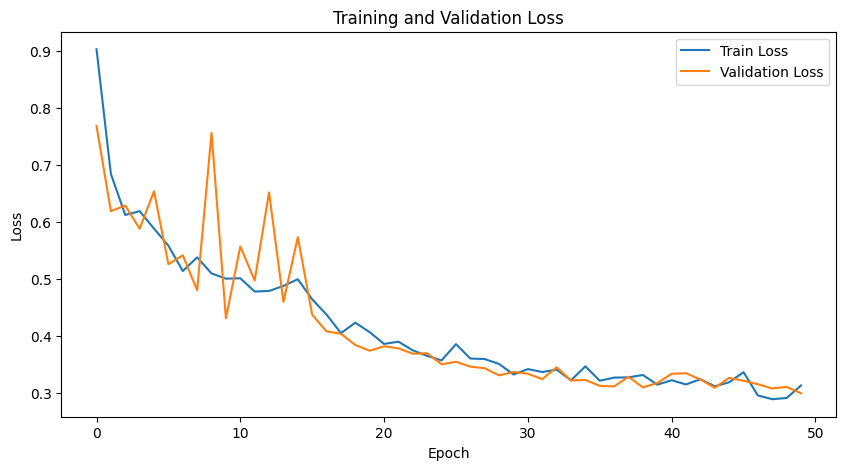

In [11]:
# 학습 손실 및 검증 손실 시각화
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# 손실 시각화
plot_losses(train_losses, val_losses)

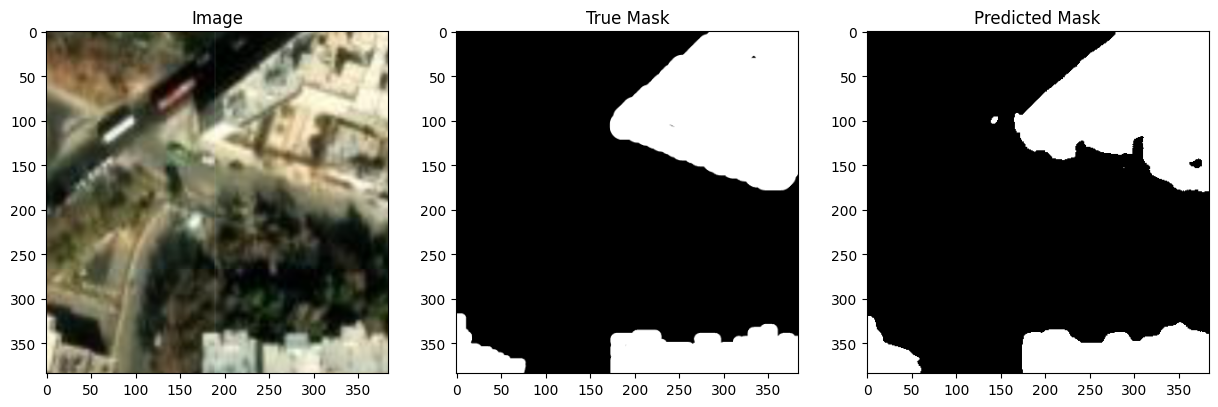

In [12]:
# 이미지와 마스크를 시각화하는 함수 (역정규화 포함)
# 이미지와 마스크를 시각화하는 함수 (역정규화 포함)
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_comparison(image, true_mask, pred_mask, mean, std):
    # Denormalize the image for visualization
    image = denormalize(image, mean, std)
    image = image.permute(1, 2, 0).cpu().numpy()  # 채널을 마지막으로 배치하고 numpy 배열로 변환
    true_mask = true_mask.cpu().numpy()
    pred_mask = pred_mask.squeeze().cpu().numpy()  # 채널 차원을 제거하여 (224, 224) 형태로 변환

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)  # 역정규화된 이미지를 시각화
    ax[0].set_title('Image')
    ax[1].imshow(true_mask, cmap='gray')
    ax[1].set_title('True Mask')
    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    plt.show()
    
# 특정 인덱스에서 이미지와 마스크 가져오기
def get_image_and_mask_at_index(dataset, index):
    image, mask = dataset[index]
    return image, mask

# 모델을 평가 모드로 전환
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# 검증 데이터셋의 특정 인덱스
index = 1  # 원하는 인덱스로 변경
image, mask = get_image_and_mask_at_index(val_dataset, index)


# 모델로 마스크 추론
with torch.no_grad():
    image = image.float().to(device).unsqueeze(0)  # 배치 차원을 추가
    mask = mask.float().to(device).unsqueeze(0)
    mask = mask / 255  # 마스크를 0과 1로 변환

    output = model(image)
    pred = torch.sigmoid(output)  # Sigmoid activation to get probability
    pred = (pred > 0.5).float()  # Binarize the outputs at 0.5 threshold

# 첫 번째 이미지와 마스크를 시각화
visualize_comparison(image.squeeze(0), mask.squeeze(0), pred.squeeze(0), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))